# INIT

In [1]:
import sys
sys.path.append('../../deconv_py/')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../infras/ctpnet/')
sys.path.append('../infras/')
sys.path.append('../infras/dashboards/')
sys.path.append('../experiments/')
sys.path.append('../experiments/pipeline/')
sys.path.append('../preprocess/intra_variance/')
sys.path.append('../models/cell_proportions/')
sys.path.append('../measures/cell_proportions_measures/')
sys.path.append('../preprocess/cell_specifics/')
sys.path.append('../preprocess/data_sets/')


In [15]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots

from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile
from pick_data_set import PickDataSet
# from deconvolution_results_plots import DeconvolutionResultsPlots

from basic import BasicDeconv
from regression import RegressionDeconv
from generalized_estimating_equations import GeneralizedEstimatingEquations
from robust_linear_model import RobustLinearModel


from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

from infras.ctpnet.ctpnet_coordinator import CtpNetCoordinator


import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


%connect_info

{
  "shell_port": 64442,
  "iopub_port": 64443,
  "stdin_port": 64444,
  "control_port": 64445,
  "hb_port": 64446,
  "ip": "127.0.0.1",
  "key": "19fbd0c4-1a8d884f19609c05bb6bd385",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4172cf43-8047-40c8-97e3-814cacd997e9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [43]:
import snakeviz
%load_ext snakeviz


# build data for test

## signature

In [16]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  


In [17]:
spec_cells = PpKeepSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()

steps_all_cells = [("kepp_specific_cells",spec_cells),("cleanHighIntraVariance",pp_chiv),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot)]

_params = {"cleanHighIntraVariance__how":"std","cleanHighIntraVariance__std_trh":4,
                   "AggregateIntraVariance__how":"median"}


pip_all_cells = pipeline.Pipeline(steps=steps_all_cells)
pip_all_cells.set_params(**_params)
_A,_ = pip_all_cells.transform([A_all_vs,A_all_vs])

In [5]:
signature_df = pd.read_csv("targeted_proteins.csv").set_index(["protein","gene"])
signature_genes = signature_df.index
A_for_test = _A.loc[signature_genes].copy(deep=True).dropna(how="all")
B_for_test = B_all_vs.dropna()

mutual_genes = A_for_test.index.intersection(B_for_test.index)
A_for_test = A_for_test.loc[mutual_genes]
B_for_test = B_for_test.loc[mutual_genes]



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


# deconvolution

## naive - first step

In [6]:
mixture_id = 15
cell_specific,mass_spec_mixture = A_for_test,B_for_test[B_for_test.columns[mixture_id]]

In [7]:
cell_specific = cell_specific/cell_specific.sum().mean()
mass_spec_mixture = mass_spec_mixture/mass_spec_mixture.sum()

In [18]:
genes_corr_df = B_for_test.T.corr()
dissimilarity = 1 - (genes_corr_df)
hierarchy = linkage(squareform(dissimilarity), method='average')
labels = fcluster(hierarchy, 0.5, criterion='distance')
idx_to_group = {idx: lab for lab, idx in zip(labels, genes_corr_df.index)}
groups_list = [idx_to_group[g] for g in mass_spec_mixture.index]

# def _deconvolution(mass_spec_mixture, cell_specific,weights=None):
#     if weights is not None : 
#         weights_vector = np.array([weights[gene] for gene in mass_spec_mixture.index.get_level_values(1)])
#         model = sm.GEE(mass_spec_mixture, cell_specific,groups=groups_list,weights=weights_vector)
#     else :
#         model = sm.GEE(mass_spec_mixture, cell_specific,groups=groups_list)
        
#     result = model.fit()
#     cell_abundance = result.params
#     cell_abundance[cell_abundance<0] = 0 
#     cell_abundance_df = pd.DataFrame(data=cell_abundance, index=cell_specific.columns, columns=[B_for_test.columns[mixture_id]])
#     return cell_abundance_df/cell_abundance_df.sum()

#     rlm_model = sm.RLM(mass_spec_mixture, cell_specific, M=sm.robust.norms.HuberT())
#             rlm_results = rlm_model.fit()
#             cell_abundance = rlm_results.params
#             cell_abundance[cell_abundance < 0] = 0

def _deconvolution(mass_spec_mixture, cell_specific,weights=None):
    mass_spec_mixture, cell_specific=mass_spec_mixture.copy(deep=True), cell_specific.copy(deep=True)
    if weights is not None : 
        
        for protein,gene in mass_spec_mixture.index : 
            mass_spec_mixture.loc[(protein,gene)] = mass_spec_mixture.loc[(protein,gene)]*weights[gene]
            cell_specific.loc[(protein,gene)] = cell_specific.loc[(protein,gene)]*weights[gene]
        
        cell_abundance = scipy.optimize.nnls(cell_specific, mass_spec_mixture)[0]
    else :
        cell_abundance = scipy.optimize.nnls(cell_specific, mass_spec_mixture)[0]
        
    cell_abundance_df = pd.DataFrame(data=cell_abundance, index=cell_specific.columns, columns=["samples"])
    return cell_abundance_df/cell_abundance_df.sum()

def calculate_weights_for_genes(all_mixture_genes,surface_proteins_genes,sum_ratio = 1) :
    surface_proteins_genes_in_mixtures = [gene for gene in surface_proteins_genes if gene in all_mixture_genes]
    
    common_genes_count = len(all_mixture_genes) - len(surface_proteins_genes_in_mixtures)
    special_gene_count = len(surface_proteins_genes_in_mixtures)
    normalization_factor = 2*common_genes_count*special_gene_count
    
    common_weigth = special_gene_count/normalization_factor
    special_weight = common_genes_count/normalization_factor
    
    gene_to_weigth = {}
    for gene in all_mixture_genes : 
        weight = special_weight if (gene in surface_proteins_genes_in_mixtures) else common_weigth
        gene_to_weigth[gene] = weight
    
    return gene_to_weigth
    
def _build_expected_sp(reconstructed_proportions,sp_profile,genes_in_signature ):
    expected_surface_proteins = sp_profile.dot(reconstructed_proportions.loc[sp_profile.columns])
    mutual_genes = expected_surface_proteins[expected_surface_proteins.index.isin(genes_in_signature)].index
    return expected_surface_proteins.loc[mutual_genes]

def change_mixture_surface_proteins_based_on_expected_order(expected_surface_proteins,mass_spec_mixture_surface_proteins):
    _expected_surface_proteins = expected_surface_proteins.sort_values(by=expected_surface_proteins.columns[0])
    new_mass_spec_mixture_surface_proteins = pd.Series(index=_expected_surface_proteins.index,name = _expected_surface_proteins.columns[0],
                                                  data = np.sort(mass_spec_mixture_surface_proteins.values))
    return new_mass_spec_mixture_surface_proteins

def update_mixture_data(mass_spec_mixture,new_mass_spec_mixture):
    mass_spec_mixture = mass_spec_mixture.copy(deep=True)
    # tmp.replace(new_mass_spec_mixture_surface_proteins.index,new_mass_spec_mixture_surface_proteins.values)
    # new_mass_spec_mixture_surface_proteins.dtype
    for protein,new_val in new_mass_spec_mixture.items() : 
        mass_spec_mixture[mass_spec_mixture.index.get_level_values(1) == protein] = new_val
    return mass_spec_mixture



In [19]:
cell_abundance_df = _deconvolution(mass_spec_mixture, cell_specific)
cell_abundance_df

,samples
cell,
Intensity NOT_BCellmemory,0.000000
Intensity NOT_BCellnaive,0.000000
Intensity NOT_BCellplasma,0.000000
Intensity NOT_CD4TCellTcm,0.000000
Intensity NOT_CD4TCellTem,0.000000
Intensity NOT_CD4TCellTemra,0.000000
Intensity NOT_CD4TCellnTregs,0.000000
Intensity NOT_CD4TCellnaive,0.000000
Intensity NOT_CD8TCellTem,0.000000


In [23]:
cell_abundance_df = _deconvolution(mass_spec_mixture, cell_specific)
cell_abundance_df

cell
Intensity NOT_BCellmemory              0.000000
Intensity NOT_BCellnaive               0.000000
Intensity NOT_BCellplasma              0.000000
Intensity NOT_CD4TCellTcm              0.000000
Intensity NOT_CD4TCellTem              0.000000
Intensity NOT_CD4TCellTemra            0.000000
Intensity NOT_CD4TCellnTregs           0.000000
Intensity NOT_CD4TCellnaive            0.000000
Intensity NOT_CD8TCellTem              0.000000
Intensity NOT_CD8TCellTemra            0.000000
Intensity NOT_CD8TCellnaive            0.000000
Intensity NOT_DendriticCD1c            0.000000
Intensity NOT_DendriticCD304           0.000000
Intensity NOT_Monocytesclassical       0.138136
Intensity NOT_Monocytesintermediate    0.305292
Intensity NOT_Monocytesnonclassical    0.000000
Intensity NOT_NKCellsCD56bright        0.000000
Intensity NOT_NKCellsCD56dim           0.000000
Name: 30_v1, dtype: float64

## expected_mixture

In [24]:
expected_mixture = cell_specific.dot(cell_abundance_df)

AttributeError: 'Series' object has no attribute 'corrwith'

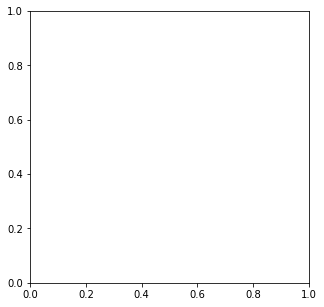

In [27]:
fig, ax = plt.subplots(1,figsize=(5,5))
print(expected_mixture.corrwith(mass_spec_mixture))
print(expected_mixture.corrwith(mass_spec_mixture,method="spearman"))
ax.scatter( expected_mixture.rank(),  mass_spec_mixture.rank())

## surface proteins

In [28]:
ctnc = CtpNetCoordinator()
sp_profile = ctnc.return_imputed_proteins_for_cells(cell_abundance_df.index.to_list())

In [29]:
expected_mixture_surface_proteins = expected_mixture.reindex(sp_profile.index,level=1).dropna()
expected_surface_proteins = sp_profile.dot(cell_abundance_df.loc[sp_profile.columns]).loc[expected_mixture_surface_proteins.index.get_level_values(1)]
mass_spec_mixture_surface_proteins = mass_spec_mixture.reindex(sp_profile.index,level=1).dropna()

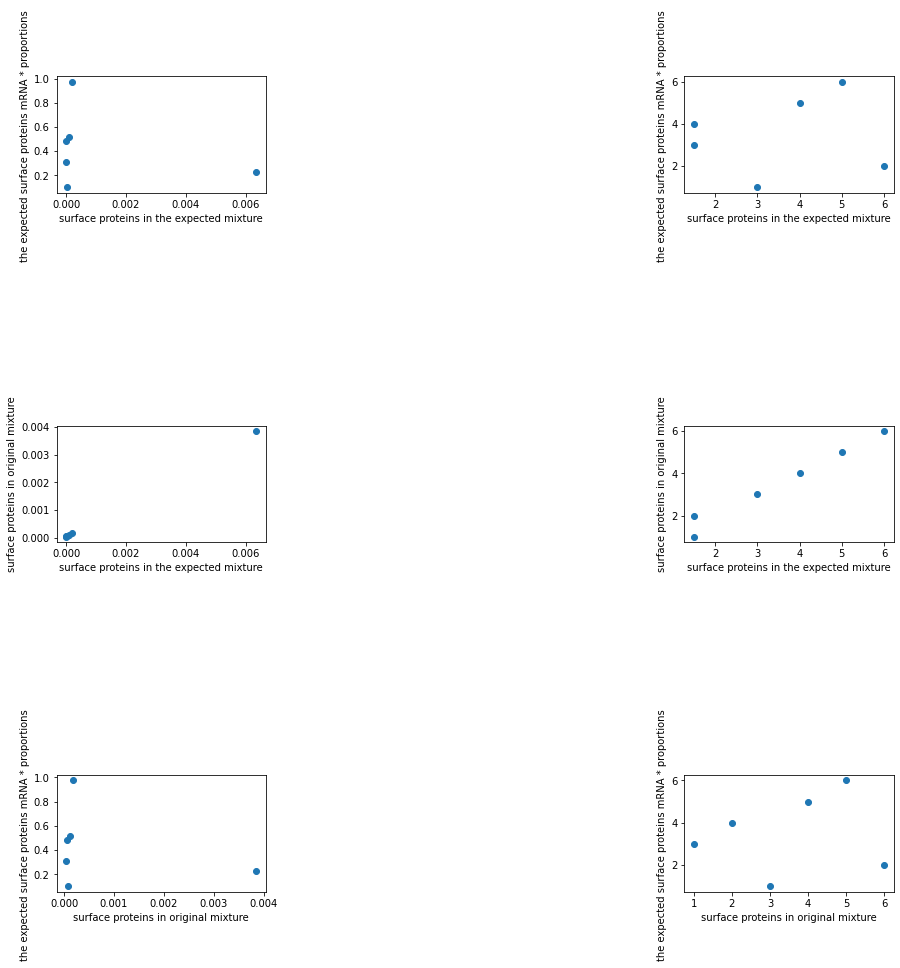

In [30]:
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0][0].scatter( expected_mixture_surface_proteins, expected_surface_proteins)
axs[0][0].set_xlabel("surface proteins in the expected mixture")
axs[0][0].set_ylabel("the expected surface proteins mRNA * proportions ")
axs[0][1].scatter( expected_mixture_surface_proteins.rank(), expected_surface_proteins.rank())
axs[0][1].set_xlabel("surface proteins in the expected mixture")
axs[0][1].set_ylabel("the expected surface proteins mRNA * proportions ")

axs[1][0].scatter( expected_mixture_surface_proteins,  mass_spec_mixture_surface_proteins)
axs[1][0].set_xlabel("surface proteins in the expected mixture")
axs[1][0].set_ylabel("surface proteins in original mixture")
axs[1][1].scatter( expected_mixture_surface_proteins.rank(), mass_spec_mixture_surface_proteins.rank())
axs[1][1].set_xlabel("surface proteins in the expected mixture")
axs[1][1].set_ylabel("surface proteins in original mixture")

axs[2][0].scatter( mass_spec_mixture_surface_proteins,  expected_surface_proteins)
axs[2][0].set_xlabel("surface proteins in original mixture")
axs[2][0].set_ylabel("the expected surface proteins mRNA * proportions ")
axs[2][1].scatter( mass_spec_mixture_surface_proteins.rank(), expected_surface_proteins.rank())
axs[2][1].set_xlabel("surface proteins in original mixture")
axs[2][1].set_ylabel("the expected surface proteins mRNA * proportions ")

plt.subplots_adjust(wspace=2,hspace=2)

## combined EM

In [31]:
mixture_id = 6
cell_specific,mass_spec_mixture = A_for_test,B_for_test[B_for_test.columns[mixture_id]]

cell_specific = cell_specific/cell_specific.sum().mean()
mass_spec_mixture = mass_spec_mixture/mass_spec_mixture.sum()

In [32]:
genes_weights = calculate_weights_for_genes(mass_spec_mixture.index.get_level_values(1).to_list(),
                                           sp_profile.index.to_list())

In [33]:
def display_scatter(first_series,second_series):
    first_series,second_series = first_series.copy(deep=True),second_series.copy(deep=True)
    if type(first_series.index) is  pd.MultiIndex  : 
        first_series = first_series.droplevel(0)
    
    if type(second_series.index) is  pd.MultiIndex  : 
        second_series = second_series.droplevel(0)
    
    if type(first_series) is pd.Series:
        first_series = first_series.rename(f"{first_series.name}_1")
    else : 
        first_series = first_series.rename(columns = {first_series.columns[0]:f"{first_series.columns[0]}_1"})
    
    
#     display(pd.concat([first_series,second_series],axis=1))
    pd.concat([first_series,second_series],axis=1).plot.scatter(0,1)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


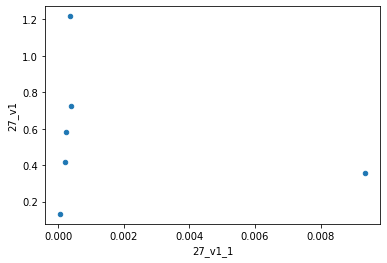

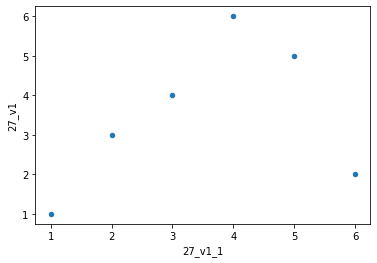

AttributeError: 'Series' object has no attribute 'columns'

In [34]:
updated_mixture = mass_spec_mixture.copy(deep=True)
reconstructed_list = [] 
for i in range(4) : 
    reconstructed_proportions = _deconvolution(updated_mixture, cell_specific,genes_weights)
    expected_surface_proteins = _build_expected_sp(reconstructed_proportions,sp_profile,mass_spec_mixture.index.get_level_values(1))
    
    surface_proteins_of_mixture = updated_mixture.loc[updated_mixture.index.get_level_values(1).isin(expected_surface_proteins.index)]
    
    display_scatter(surface_proteins_of_mixture,expected_surface_proteins)
    display_scatter(surface_proteins_of_mixture.rank(),expected_surface_proteins.rank())
    
    new_surface_protein_mixture_values = change_mixture_surface_proteins_based_on_expected_order(
        expected_surface_proteins,surface_proteins_of_mixture)
    
    updated_mixture = update_mixture_data(updated_mixture,new_surface_protein_mixture_values)
    reconstructed_list.append(reconstructed_proportions.rename(columns={reconstructed_proportions.columns[0]:f"{reconstructed_proportions.columns[0]}_{i}"}))

    print("----")
    
pd.concat(reconstructed_list,axis=1)
    

# speed test

In [ ]:
def _deconvolution(mass_spec_mixture, cell_specific, weights=None):
    mass_spec_mixture, cell_specific = mass_spec_mixture.copy(deep=True), cell_specific.copy(deep=True)

    if weights is not None:
        for protein, gene in mass_spec_mixture.index:
            mass_spec_mixture.loc[(protein, gene)] = mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])
            cell_specific.loc[(protein, gene)] = cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])

        cell_abundance = scipy.optimize.nnls(cell_specific, mass_spec_mixture)[0]
    else:
        cell_abundance = scipy.optimize.nnls(cell_specific, mass_spec_mixture)[0]

    cell_abundance = pd.Series(data=cell_abundance, index=cell_specific.columns,name=mass_spec_mixture.name)
    return cell_abundance

    # region private

def em_deconvolution(mass_spec_mixture, cell_specific, sp_profile, genes_weights=None):
    updated_mixture = mass_spec_mixture.copy(deep=True)

    for i in range(4):
        reconstructed_proportions = _deconvolution(updated_mixture, cell_specific, genes_weights)
        expected_surface_proteins = _build_expected_sp(reconstructed_proportions, sp_profile,
                                                            mass_spec_mixture.index.get_level_values(1))

        surface_proteins_of_mixture = updated_mixture.loc[
            updated_mixture.index.get_level_values(1).isin(expected_surface_proteins.index)]

        new_surface_protein_mixture_values = change_mixture_surface_proteins_based_on_expected_order(
            expected_surface_proteins, surface_proteins_of_mixture)

        updated_mixture = update_mixture_data(updated_mixture, new_surface_protein_mixture_values)

    return reconstructed_proportions

In [71]:
def __calculate_weights_for_genes(all_mixture_genes, surface_proteins_genes, sum_ratio=1):
    surface_proteins_genes_in_mixtures = [gene for gene in surface_proteins_genes if gene in all_mixture_genes]

    common_genes_count = len(all_mixture_genes) - len(surface_proteins_genes_in_mixtures)
    special_gene_count = len(surface_proteins_genes_in_mixtures)
    normalization_factor = 2 * common_genes_count * special_gene_count

    common_weigth = special_gene_count / normalization_factor
    special_weight = common_genes_count / normalization_factor

    gene_to_weigth = {}
    for gene in all_mixture_genes:
        weight = special_weight if (gene in surface_proteins_genes_in_mixtures) else common_weigth
        gene_to_weigth[gene] = weight

    return gene_to_weigth

def _get_gene_weights(cell_specific, predicted_sp_genes):
    gene_weights = __calculate_weights_for_genes(cell_specific.index.get_level_values(1).to_list(),
                                                      predicted_sp_genes.index.to_list())
    return gene_weights

def _update_mixtures_by_weight(mass_spec_mixture,cell_specific,weights) :
    mass_spec_mixture, cell_specific = mass_spec_mixture.copy(deep=True), cell_specific.copy(deep=True)

    tmp_mass_spec_as_list = []
    tmp_cell_specific_as_list = []

    for protein, gene in mass_spec_mixture.index:
        tmp_mass_spec_as_list.append([protein, gene,mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])])
        tmp_cell_specific_as_list.append([protein, gene]+(cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())
#             mass_spec_mixture.loc[(protein, gene)] = mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])
#             cell_specific.loc[(protein, gene)] = cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])

    _mass_spec_mixture = pd.DataFrame(columns=["protein","gene",mass_spec_mixture.name],data=tmp_mass_spec_as_list)
    mass_spec_mixture = _mass_spec_mixture.set_index(["protein","gene"])[mass_spec_mixture.name]
    _cell_specific = pd.DataFrame(columns = ["protein","gene"] + cell_specific.columns.to_list(),data=tmp_cell_specific_as_list)
    cell_specific = _cell_specific.set_index(["protein","gene"])
    
    return mass_spec_mixture,cell_specific

    

def _deconvolution(mass_spec_mixture, cell_specific,genes_weights=None):
    cell_abundance = scipy.optimize.nnls(cell_specific, mass_spec_mixture)[0]
    cell_abundance = pd.Series(data=cell_abundance, index=cell_specific.columns,name=mass_spec_mixture.name)
    return cell_abundance

def em_deconvolution(mass_spec_mixture, cell_specific, sp_profile, genes_weights=None):
    updated_mixture = mass_spec_mixture.copy(deep=True)

    for i in range(4):
        reconstructed_proportions = _deconvolution(updated_mixture, cell_specific, genes_weights)
        expected_surface_proteins = _build_expected_sp(reconstructed_proportions, sp_profile,
                                                            mass_spec_mixture.index.get_level_values(1))

        surface_proteins_of_mixture = updated_mixture.loc[
            updated_mixture.index.get_level_values(1).isin(expected_surface_proteins.index)]

        new_surface_protein_mixture_values = change_mixture_surface_proteins_based_on_expected_order(
            expected_surface_proteins, surface_proteins_of_mixture)

        updated_mixture = update_mixture_data(updated_mixture, new_surface_protein_mixture_values)

    return reconstructed_proportions

def _build_expected_sp(reconstructed_proportions, sp_profile, genes_in_signature):
    expected_surface_proteins = sp_profile.dot(reconstructed_proportions.loc[sp_profile.columns])
    mutual_genes = expected_surface_proteins[expected_surface_proteins.index.isin(genes_in_signature)].index
    expected_surface_proteins = expected_surface_proteins._set_name(reconstructed_proportions.name)

    return expected_surface_proteins.loc[mutual_genes]

def change_mixture_surface_proteins_based_on_expected_order(expected_surface_proteins,
                                                            mass_spec_mixture_surface_proteins):
    _expected_surface_proteins = expected_surface_proteins.sort_values()
    new_mass_spec_mixture_surface_proteins = pd.Series(index=_expected_surface_proteins.index,
                                                       name=_expected_surface_proteins.name,
                                                       data=np.sort(mass_spec_mixture_surface_proteins.values))
    return new_mass_spec_mixture_surface_proteins

def update_mixture_data(mass_spec_mixture, new_mass_spec_mixture):
    mass_spec_mixture = mass_spec_mixture.copy(deep=True)

    for protein, new_val in new_mass_spec_mixture.items():
        mass_spec_mixture[mass_spec_mixture.index.get_level_values(1) == protein] = new_val
    return mass_spec_mixture


In [76]:
%%timeit
genes_weights = _get_gene_weights(cell_specific,sp_profile)

for mixture_id in range(B_for_test.shape[1]) : 
    mass_spec_mixture = B_for_test[B_for_test.columns[mixture_id]]
    mass_spec_mixture = mass_spec_mixture/mass_spec_mixture.sum()
    
    _mass_spec_mixture,_cell_specific = _update_mixtures_by_weight(mass_spec_mixture,cell_specific,genes_weights)
    em_deconvolution(_mass_spec_mixture,_cell_specific,sp_profile,genes_weights)
#     em_deconvolution(mass_spec_mixture,cell_specific,sp_profile,None)

36.8 s ± 2.82 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
def _update_mixtures_by_weight_v1(mass_spec_mixture,cell_specific,weights) :
    mass_spec_mixture, cell_specific = mass_spec_mixture.copy(deep=True), cell_specific.copy(deep=True)

    tmp_mass_spec_as_list = []
    tmp_cell_specific_as_list = []

    for protein, gene in mass_spec_mixture.index:
        tmp_mass_spec_as_list.append([protein, gene,mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])])
        tmp_cell_specific_as_list.append([protein, gene]+(cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())

    _mass_spec_mixture = pd.DataFrame(columns=["protein","gene",mass_spec_mixture.name],data=tmp_mass_spec_as_list)
    mass_spec_mixture = _mass_spec_mixture.set_index(["protein","gene"])[mass_spec_mixture.name]
    _cell_specific = pd.DataFrame(columns = ["protein","gene"] + cell_specific.columns.to_list(),data=tmp_cell_specific_as_list)
    cell_specific = _cell_specific.set_index(["protein","gene"])
    
    return mass_spec_mixture,cell_specific

def _update_mixtures_by_weight_v2(mass_spec_mixture,cell_specific,weights) :
    mass_spec_mixture, cell_specific = mass_spec_mixture.copy(deep=True), cell_specific.copy(deep=True)

    tmp_mass_spec_as_list = []
    tmp_cell_specific_as_list = []

    for protein, gene in mass_spec_mixture.index:
#         tmp_mass_spec_as_list.append([protein, gene,mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])])
#         tmp_cell_specific_as_list.append([protein, gene]+(cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())
        mass_spec_mixture.loc[(protein, gene)] = mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])
        cell_specific.loc[(protein, gene)] = cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])

#     _mass_spec_mixture = pd.DataFrame(columns=["protein","gene",mass_spec_mixture.name],data=tmp_mass_spec_as_list)
#     mass_spec_mixture = _mass_spec_mixture.set_index(["protein","gene"])[mass_spec_mixture.name]
#     _cell_specific = pd.DataFrame(columns = ["protein","gene"] + cell_specific.columns.to_list(),data=tmp_cell_specific_as_list)
#     cell_specific = _cell_specific.set_index(["protein","gene"])
    
    return mass_spec_mixture,cell_specific

In [90]:
def _update_mixtures_by_weight(mass_spec_mixture,cell_specific,weights) :
    mass_spec_mixture, cell_specific = mass_spec_mixture.copy(deep=True), cell_specific.copy(deep=True)

    tmp_mass_spec_as_list = []
    tmp_cell_specific_as_list = []

    for protein, gene in mass_spec_mixture.index:
        tmp_mass_spec_as_list.append([protein, gene]+(mass_spec_mixture.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())
        tmp_cell_specific_as_list.append([protein, gene]+(cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())

    _mass_spec_mixture = pd.DataFrame(columns=["protein","gene"]+mass_spec_mixture.columns.to_list(),data=tmp_mass_spec_as_list)
    mass_spec_mixture = _mass_spec_mixture.set_index(["protein","gene"])
    _cell_specific = pd.DataFrame(columns = ["protein","gene"] + cell_specific.columns.to_list(),data=tmp_cell_specific_as_list)
    cell_specific = _cell_specific.set_index(["protein","gene"])
    
    return mass_spec_mixture,cell_specific

In [97]:

new_ms,new_cp=_update_mixtures_by_weight_v3(B_for_test,cell_specific,genes_weights)

In [105]:
%%timeit
genes_weights = _get_gene_weights(cell_specific,sp_profile)
new_ms,new_cp=_update_mixtures_by_weight_v3(B_for_test,cell_specific,genes_weights)

for mixture_id in range(B_for_test.shape[1]) : 
    mass_spec_mixture = new_ms[new_ms.columns[mixture_id]]
    mass_spec_mixture = mass_spec_mixture/mass_spec_mixture.sum()
    
    em_deconvolution(mass_spec_mixture,new_cp,sp_profile,None)


4.14 s ± 76.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


True